In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Data Preprocessing**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
# Separate features and target variable
data = pd.read_csv('data.csv')
X = data.drop('Bankrupt?', axis=1)
y = data['Bankrupt?']
# Step 3: Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Step 4: Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_balanced_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

**Logistic Regression**

Best Hyperparameters: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Optimized Logistic Regression Accuracy: 0.895405669599218
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1980
           1       0.21      0.82      0.34        66

    accuracy                           0.90      2046
   macro avg       0.60      0.86      0.64      2046
weighted avg       0.97      0.90      0.92      2046



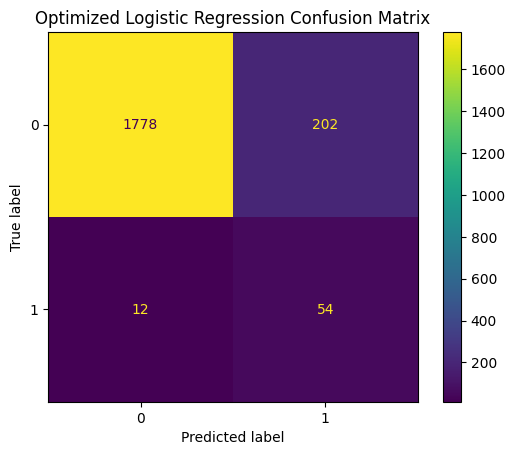

In [ ]:
# Step 6: Feature selection using Recursive Feature Elimination (RFE)
log_reg_base = LogisticRegression(max_iter=1000, solver='liblinear')
rfe = RFE(log_reg_base, n_features_to_select=10)  # Selecting top 10 features
X_train_rfe = rfe.fit_transform(X_train_balanced_scaled, y_train_balanced)
X_test_rfe = rfe.transform(X_test_scaled)

# Update param_grid to avoid incompatible solver-penalty pairs
param_grid = [
    {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2'], 'solver': ['lbfgs', 'liblinear']},
    {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1'], 'solver': ['liblinear', 'saga']}
]

# Perform GridSearchCV with updated parameters
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_rfe, y_train_balanced)

# Best parameters and model after GridSearchCV
best_log_reg_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

# Make predictions using the optimized model
y_pred_log_reg = best_log_reg_model.predict(X_test_rfe)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred_log_reg)
print("Optimized Logistic Regression Accuracy:", accuracy)
print(classification_report(y_test, y_pred_log_reg))

# Step 10: Display the confusion matrix
ConfusionMatrixDisplay.from_estimator(best_log_reg_model, X_test_rfe, y_test)
plt.title("Optimized Logistic Regression Confusion Matrix")
plt.show()

**XGBoost**

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Initialize the XGBoost model without use_label_encoder
xgb_model = XGBClassifier(eval_metric='logloss')

# Train the XGBoost model
xgb_model.fit(X_train_balanced_scaled, y_train_balanced)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate the model
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Accuracy:", xgb_accuracy)


XGBoost Accuracy: 0.9652981427174976


**XGBoost Visualization**

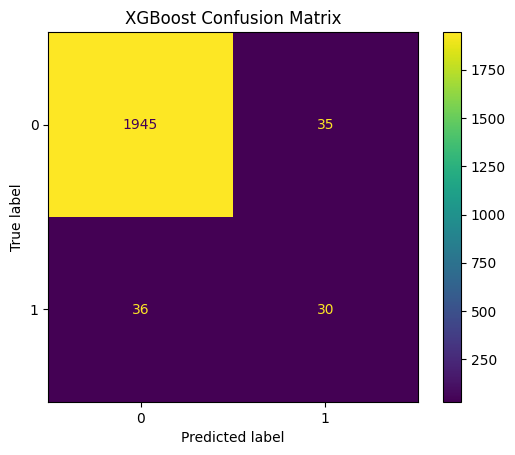

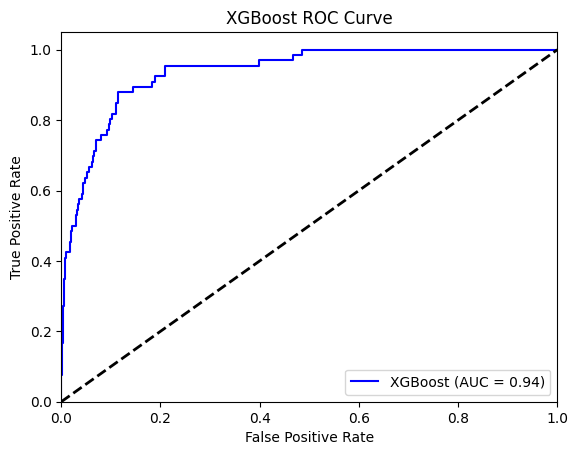

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1980
           1       0.46      0.45      0.46        66

    accuracy                           0.97      2046
   macro avg       0.72      0.72      0.72      2046
weighted avg       0.97      0.97      0.97      2046



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc, classification_report

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(xgb_model, X_test_scaled, y_test)
plt.title("XGBoost Confusion Matrix")
plt.show()

# ROC Curve
# For XGBoost, predict_proba gives the probability of class 0 and class 1, we take probability of class 1
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Calculate the FPR and TPR for the ROC curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)

# Compute AUC (Area Under the Curve)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot ROC Curve
plt.figure()
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Optional: Print Classification Report for more insights
print(classification_report(y_test, xgb_model.predict(X_test_scaled)))



**Support Vector Machine**

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Step 1: Initialize the SVM model
svm_model = SVC(kernel='rbf', probability=True)

# Step 2: Train the SVM model
svm_model.fit(X_train_balanced_scaled, y_train_balanced)

# Step 3: Make predictions
y_pred_svm = svm_model.predict(X_test_scaled)

# Step 4: Evaluate the model
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print("SVM Accuracy:", svm_accuracy)



SVM Accuracy: 0.9242424242424242


**Support Vector Machine Visualization**

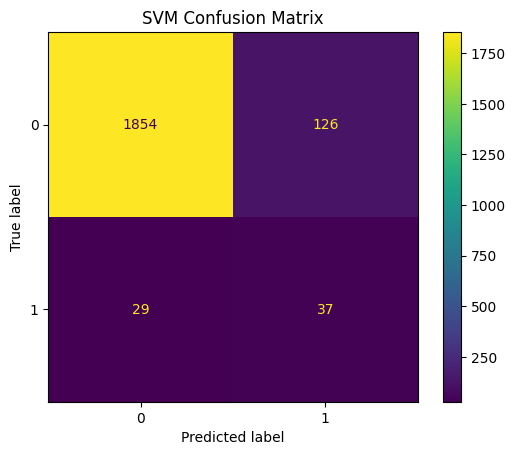

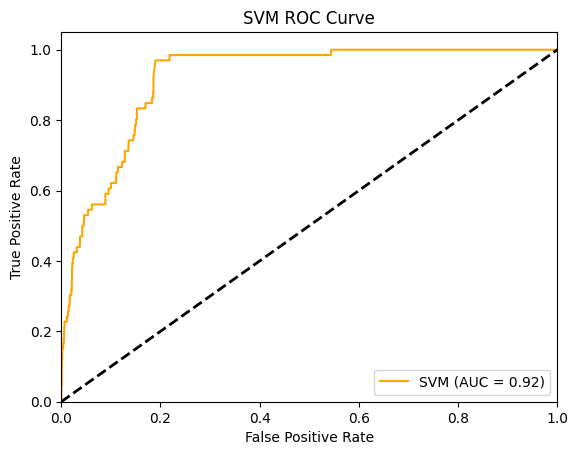

In [ ]:
# Confusion Matrix for SVM
ConfusionMatrixDisplay.from_estimator(svm_model, X_test_scaled, y_test)
plt.title("SVM Confusion Matrix")
plt.show()

# ROC Curve for SVM
# Ensure that `probability=True` was set while initializing the SVM model
y_pred_proba_svm = svm_model.predict_proba(X_test_scaled)[:, 1]  # Get probabilities for class 1

# Compute False Positive Rate and True Positive Rate
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_proba_svm)

# Compute AUC (Area Under the Curve)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Plot ROC Curve
plt.figure()
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.2f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve')
plt.legend(loc="lower right")
plt.show()



**Classification By Deep Neural Network**

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9062 - loss: 1.7677 - val_accuracy: 0.9677 - val_loss: 18683020.0000 - learning_rate: 0.0010
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9670 - loss: 0.5502 - val_accuracy: 0.9682 - val_loss: 7964365.0000 - learning_rate: 0.0010
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9664 - loss: 0.2733 - val_accuracy: 0.9687 - val_loss: 2207645.5000 - learning_rate: 0.0010
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9679 - loss: 0.1781 - val_accuracy: 0.9687 - val_loss: 706579.6875 - learning_rate: 0.0010
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9697 - loss: 0.1418 - val_accuracy: 0.9687 - val_loss: 745109.9375 - learning_rate: 0.0010
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9714 - loss: 0.1221 - val_accuracy: 0.9673 - val_loss: 389545.3750 - learning_rate: 5.0000e-04
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accurac

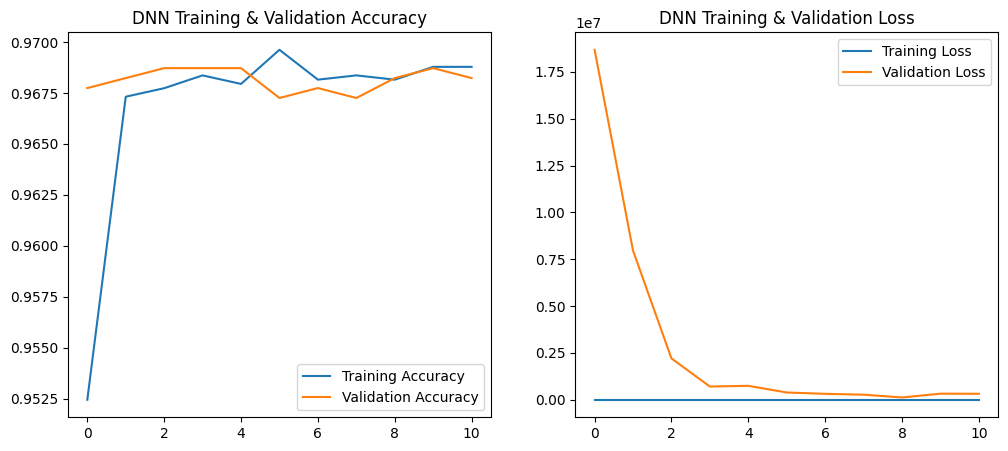

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the DNN model with increased regularization
dnn_model = Sequential([
    Dense(128, input_shape=(X_train_scaled.shape[1],), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.4),  # Increased dropout rate
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.4),  # Increased dropout rate
    Dense(1, activation='sigmoid')
])

# Compile the model
dnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback with patience reduced to 2
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.0001)

# Train the model with both early stopping and learning rate reduction
history = dnn_model.fit(X_train_scaled, y_train, epochs=20, batch_size=32,
                        validation_data=(X_test_scaled, y_test),
                        callbacks=[early_stopping, reduce_lr])

# Evaluate the model
loss, accuracy = dnn_model.evaluate(X_test_scaled, y_test)
print("DNN Accuracy:", accuracy)

# Plotting the training history
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('DNN Training & Validation Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('DNN Training & Validation Loss')
plt.legend()

plt.show()


**Confusion Matrix For DNN**

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


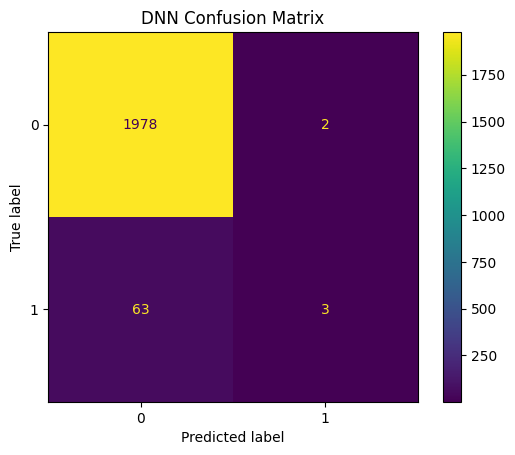

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Get predictions from the DNN model
y_pred_dnn = (dnn_model.predict(X_test_scaled) > 0.5).astype("int32")

# Plot the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dnn)
plt.title("DNN Confusion Matrix")
plt.show()



**ROC Curve for DNN**

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


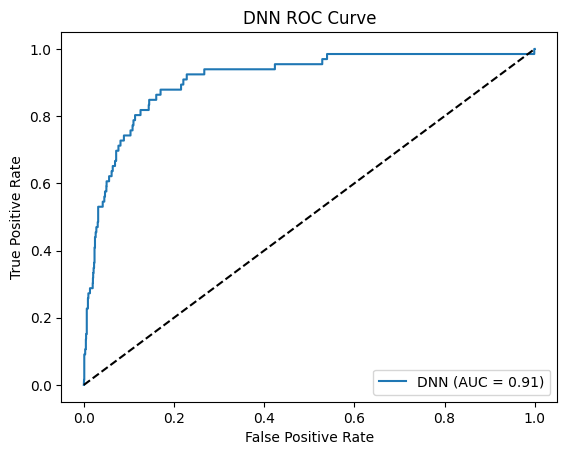

In [ ]:
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities
y_pred_proba_dnn = dnn_model.predict(X_test_scaled).ravel()

# Compute ROC curve and AUC
fpr_dnn, tpr_dnn, _ = roc_curve(y_test, y_pred_proba_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)

# Plot ROC curve
plt.figure()
plt.plot(fpr_dnn, tpr_dnn, label=f'DNN (AUC = {roc_auc_dnn:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('DNN ROC Curve')
plt.legend(loc="lower right")
plt.show()
